In [6]:
import lightning as pl
pl.__version__

docs_url = f'https://lightning.ai/docs/pytorch/stable/#get-started'
docs_url

'https://lightning.ai/docs/pytorch/stable/#get-started'

#### `pl.LightningModule` is a subclass of `torch.nn.Module`

In [7]:
import torch

issubclass(pl.LightningModule, torch.nn.Module)

True

In [9]:
from text_recognizer.lit_models import BaseLitModel

BaseLitModel??

Init signature: BaseLitModel(model, args: argparse.Namespace = None)
Source:        
class BaseLitModel(pl.LightningModule):
    """
    Generic PyTorch-Lightning class that must be initialized with a PyTorch module.
    """

    def __init__(self, model, args: argparse.Namespace = None):
        super().__init__()
        self.model = model
        self.args = vars(args) if args is not None else {}

        self.data_config = self.model.data_config
        self.mapping = self.data_config["mapping"]
        self.input_dims = self.data_config["input_dims"]

        optimizer = self.args.get("optimizer", OPTIMIZER)
        self.optimizer_class = getattr(torch.optim, optimizer)

        self.lr = self.args.get("lr", LR)

        loss = self.args.get("loss", LOSS)
        if loss not in ("transformer",):
            self.loss_fn = getattr(torch.nn.functional, loss)

        self.one_cycle_max_lr = self.args.get("one_cycle_max_lr", None)
        self.one_cycle_total_steps = self.args.get("o

In [12]:
class LinearRegression(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torch.nn.Linear(in_features=1,
                                     out_features=1)
        
    def forward(self, xs):
        return self.model(xs)

In [13]:
import logging #import some stdlb compenetes to control what's display 
import textwrap
import traceback

try:
    logging.getLogger("lightning").setLevel(logging.ERROR)
    
    model = LinearRegression()
    
    trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu', max_epochs=1)
    trainer.fit(model=model)
    
except pl.utilities.exceptions.MisconfigurationException as error:
    print("Error:", *textwrap.wrap(str(error), 80), sep='\n\t')
    
finally:
    logging.getLogger("lightning").setLevel(logging.INFO)
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/stanley/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


AttributeError: module 'lightning' has no attribute 'utilities'

In [108]:
from typing import Tuple


def training_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    xs, ys = batch  # unpack the batch
    outs = self(xs)  # apply the model
    loss = torch.nn.functional.mse_loss(outs, ys)  # compute the (squared error) loss
    return loss


LinearRegression.training_step = training_step

In [109]:
BaseLitModel.training_step??

Signature: BaseLitModel.training_step(self, batch, batch_idx)
Docstring:
Here you compute and return the training loss and some additional metrics for e.g. the progress bar or
logger.

Args:
    batch: The output of your data iterable, normally a :class:`~torch.utils.data.DataLoader`.
    batch_idx: The index of this batch.
    dataloader_idx: The index of the dataloader that produced this batch.
        (only if multiple dataloaders used)

Return:
    - :class:`~torch.Tensor` - The loss tensor
    - ``dict`` - A dictionary. Can include any keys, but must include the key ``'loss'``.
    - ``None`` - Skip to the next batch. This is only supported for automatic optimization.
        This is not supported for multi-GPU, TPU, IPU, or DeepSpeed.

In this step you'd normally do the forward pass and calculate the loss for a batch.
You can also do fancier things like multiple forward passes or something model specific.

Example::

    def training_step(self, batch, batch_idx):
        x, y, z 

In [110]:
BaseLitModel._run_on_batch??

Signature: BaseLitModel._run_on_batch(self, batch, with_preds=False)
Docstring: <no docstring>
Source:   
    def _run_on_batch(self, batch, with_preds=False):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        return x, y, logits, loss
File:      ~/Documents/shidder/ml/FullStackDL/fsdl-2022-labs/lab02/text_recognizer/lit_models/base.py
Type:      function

In [111]:
def configure_optimizer(self: LinearRegression) -> torch.optim.Optimizer:
    optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
    return optimizer

LinearRegression.configure_optimizers = configure_optimizer

In [112]:
BaseLitModel.configure_optimizers??

Signature: BaseLitModel.configure_optimizers(self)
Docstring:
Choose what optimizers and learning-rate schedulers to use in your optimization. Normally you'd need one.
But in the case of GANs or similar you might have multiple. Optimization with multiple optimizers only works in
the manual optimization mode.

Return:
    Any of these 6 options.

    - **Single optimizer**.
    - **List or Tuple** of optimizers.
    - **Two lists** - The first list has multiple optimizers, and the second has multiple LR schedulers
      (or multiple ``lr_scheduler_config``).
    - **Dictionary**, with an ``"optimizer"`` key, and (optionally) a ``"lr_scheduler"``
      key whose value is a single LR scheduler or ``lr_scheduler_config``.
    - **None** - Fit will run without any optimizer.

The ``lr_scheduler_config`` is a dictionary which contains the scheduler and its associated configuration.
The default configuration is shown below.

.. code-block:: python

    lr_scheduler_config = {
        # REQUIR

In [113]:
trainer = pl.Trainer(max_epochs=20, accelerator='gpu')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [154]:
class CorrelatedDataset(torch.utils.data.Dataset):

    def __init__(self, N=10_000):
        self.N = N
        self.xs = torch.randn(size=(N, 1))
        self.ys = torch.randn_like(self.xs) + self.xs  # correlated target data: y ~ N(x, 1)

    def __getitem__(self, idx):
        return (self.xs[idx], self.ys[idx])

    def __len__(self):
        return self.N


dataset = CorrelatedDataset()
tdl = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1)

In [155]:
example_xs, example_ys = next(iter(tdl))


In [156]:
print("xs:", example_xs[:10], sep="\n")
print("ys:", example_ys[:10], sep="\n")

xs:
tensor([[-0.2429],
        [-0.9342],
        [-0.2483],
        [-1.2082],
        [-0.4777],
        [ 0.5201],
        [ 1.6423],
        [-0.1596],
        [ 2.3228],
        [-0.9634]])
ys:
tensor([[ 0.3856],
        [ 0.0418],
        [-1.5879],
        [-1.6987],
        [ 1.5918],
        [ 1.1458],
        [ 2.8387],
        [-0.7786],
        [ 3.4444],
        [-1.8255]])


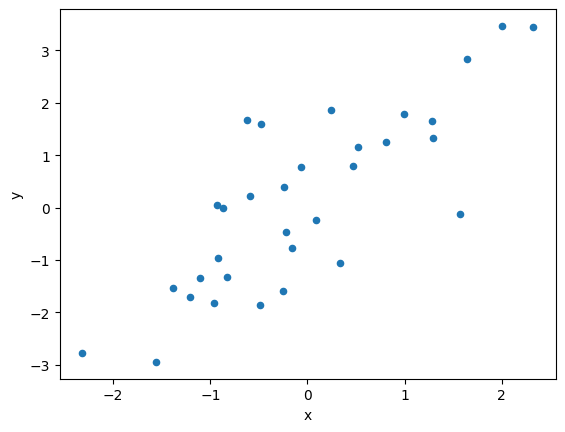

In [157]:
import pandas as pd


pd.DataFrame(data={"x": example_xs.flatten(), "y": example_ys.flatten()})\
  .plot(x="x", y="y", kind="scatter");

In [158]:
model = LinearRegression()

print(f"Loss before trianing: {torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item()}")

trainer.fit(model=model, train_dataloaders=tdl)

print(f"Loss after training {torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item()}")

/home/stanley/miniconda3/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory /home/stanley/Documents/shidder/ml/FullStackDL/fsdl-2022-labs/lab02/lightning_logs/version_5/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Loss before trianing: 3.4017789363861084


/home/stanley/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.


Loss after training 3.4017789363861084


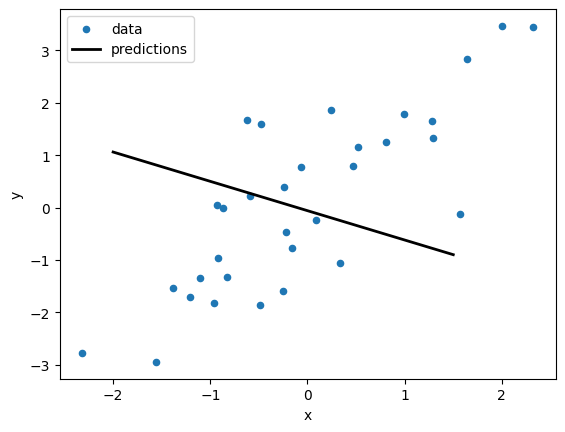

In [159]:
ax = pd.DataFrame(data={"x": example_xs.flatten(), "y": example_ys.flatten()})\
  .plot(x="x", y="y", legend=True, kind="scatter", label="data")

inps = torch.arange(-2, 2, 0.5)[:, None]
ax.plot(inps, model(inps).detach(), lw=2, color="k", label="predictions"); ax.legend();

In [120]:
pl.Trainer.__init__.__doc__.strip().split("\n")[0]

'Customize every aspect of training via flags.'

In [121]:
print(pl.Trainer.__init__.__doc__)

Customize every aspect of training via flags.

        Args:
            accelerator: Supports passing different accelerator types ("cpu", "gpu", "tpu", "ipu", "hpu", "mps", "auto")
                as well as custom accelerator instances.

            strategy: Supports different training strategies with aliases as well custom strategies.
                Default: ``"auto"``.

            devices: The devices to use. Can be set to a positive number (int or str), a sequence of device indices
                (list or str), the value ``-1`` to indicate all available devices should be used, or ``"auto"`` for
                automatic selection based on the chosen accelerator. Default: ``"auto"``.

            num_nodes: Number of GPU nodes for distributed training.
                Default: ``1``.

            precision: Double precision (64, '64' or '64-true'), full precision (32, '32' or '32-true'),
                16bit mixed precision (16, '16', '16-mixed') or bfloat16 mixed precision ('

In [122]:
!ls text_recognizer/lit_models

base.py  __init__.py  __pycache__


In [160]:
!ls training

__init__.py  __pycache__  run_experiment.py  util.py


In [161]:
import training.run_experiment


print(training.run_experiment.__doc__, training.run_experiment.main.__doc__)

Experiment-running framework. 
    Run an experiment.

    Sample command:
    ```
    python training/run_experiment.py --max_epochs=3 --gpus='0,' --num_workers=20 --model_class=MLP --data_class=MNIST
    ```

    For basic help documentation, run the command
    ```
    python training/run_experiment.py --help
    ```

    The available command line args differ depending on some of the arguments, including --model_class and --data_class.

    To see which command line args are available and read their documentation, provide values for those arguments
    before invoking --help, like so:
    ```
    python training/run_experiment.py --model_class=MLP --data_class=MNIST --help
    


In [162]:
# how the trainer is initialized in the training script
!grep "pl.Trainer.from" training/run_experiment.py

    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks, logger=logger)


In [163]:
# displays the first few flags for controlling the Trainer from the command line
!python training/run_experiment.py --help | grep "pl.Trainer" -A 24

Traceback (most recent call last):
  File "/home/stanley/Documents/shidder/ml/FullStackDL/fsdl-2022-labs/lab02/training/run_experiment.py", line 10, in <module>
    from text_recognizer import lit_models
ModuleNotFoundError: No module named 'text_recognizer'


The `LightningModule` and the `Trainer` are the minimum amount you need
to get started with PyTorch Lightning.

But they aren't all you need.

There are many more features built into Lightning and its ecosystem.

We'll cover three more here:
- `pl.LightningDataModule`s, for organizing dataloaders and handling data in distributed settings
- `pl.Callback`s, for adding "optional" extra features to model training
- `torchmetrics`, for efficiently computing and logging 

In [164]:
import math


class CorrelatedDataModule(pl.LightningDataModule):

    def __init__(self, size=10_000, train_frac=0.8, batch_size=32):
        super().__init__()  # again, mandatory superclass init, as with torch.nn.Modules

        # set some constants, like the train/val split
        self.size = size
        self.train_frac, self.val_frac = train_frac, 1 - train_frac
        self.train_indices = list(range(math.floor(self.size * train_frac)))
        self.val_indices = list(range(self.train_indices[-1], self.size))

        # under the hood, we've still got a torch Dataset
        self.dataset = CorrelatedDataset(N=size)

In [165]:
def setup(self, stage=None):  # prepares state that needs to be set for each GPU on each node
    if stage == "fit" or stage is None:  # other stages: "test", "predict"
        self.train_dataset = torch.utils.data.Subset(self.dataset, self.train_indices)
        self.val_dataset = torch.utils.data.Subset(self.dataset, self.val_indices)

def prepare_data(self):  # prepares state that needs to be set once per node
    pass  # but we don't have any "node-level" computations


CorrelatedDataModule.setup, CorrelatedDataModule.prepare_data = setup, prepare_data

In [166]:
def train_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(self.train_dataset, batch_size=32)

def val_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(self.val_dataset, batch_size=32)

CorrelatedDataModule.train_dataloader, CorrelatedDataModule.val_dataloader = train_dataloader, val_dataloader

In [167]:
model = LinearRegression()
datamodule = CorrelatedDataModule()

dataset = datamodule.dataset

print("loss before training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

trainer = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer.fit(model=model, datamodule=datamodule)

print("loss after training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

loss before training: 3.3570358753204346


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/stanley/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/home/stanley/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:  13%|█▎        | 32/250 [00:00<00:01, 145.43it/s, v_num=8]

Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 151.24it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 150.73it/s, v_num=8]
loss after training: 1.5875164270401


In [174]:
from text_recognizer.data import BaseDataModule


BaseDataModule??

Init signature: BaseDataModule(args: argparse.Namespace = None) -> None
Source:        
class BaseDataModule(pl.LightningDataModule):
    """Base for all of our LightningDataModules.

    Learn more at about LDMs at https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html
    """

    def __init__(self, args: argparse.Namespace = None) -> None:
        super().__init__()
        self.args = vars(args) if args is not None else {}
        self.batch_size = self.args.get("batch_size", BATCH_SIZE)
        self.num_workers = self.args.get("num_workers", DEFAULT_NUM_WORKERS)

        self.on_gpu = isinstance(self.args.get("gpus", None), (str, int))

        # Make sure to set the variables below in subclasses
        self.input_dims: Tuple[int, ...]
        self.output_dims: Tuple[int, ...]
        self.mapping: Collection
        self.data_train: Union[BaseDataset, ConcatDataset]
        self.data_val: Union[BaseDataset, ConcatDataset]
        self.data_test: Union[Bas

In [175]:
from text_recognizer.data.mnist import MNIST


MNIST??

Init signature: MNIST(args: argparse.Namespace) -> None
Source:        
class MNIST(BaseDataModule):
    """MNIST DataModule."""

    def __init__(self, args: argparse.Namespace) -> None:
        super().__init__(args)
        self.data_dir = metadata.DOWNLOADED_DATA_DIRNAME
        self.transform = MNISTStem()
        self.input_dims = metadata.DIMS
        self.output_dims = metadata.OUTPUT_DIMS
        self.mapping = metadata.MAPPING

    def prepare_data(self, *args, **kwargs) -> None:
        """Download train and test MNIST data from PyTorch canonical source."""
        TorchMNIST(self.data_dir, train=True, download=True)
        TorchMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None) -> None:
        """Split into train, val, test, and set dims."""
        mnist_full = TorchMNIST(self.data_dir, train=True, transform=self.transform)
        self.data_train, self.data_val = random_split(mnist_full, [metadata.TRAIN_SIZE, metadata.VAL_SIZE])  # type: i

In [201]:
import lightning as pl

In [202]:
pl.callbacks.__all__  # builtin Callbacks from Lightning

AttributeError: module 'lightning' has no attribute 'callbacks'

In [203]:
hooks = ", ".join([method for method in dir(pl.Callback) if method.startswith("on_")])
print("hooks:", *textwrap.wrap(hooks, width=80), sep="\n\t")

hooks:
	on_after_backward, on_before_backward, on_before_optimizer_step,
	on_before_zero_grad, on_exception, on_fit_end, on_fit_start, on_load_checkpoint,
	on_predict_batch_end, on_predict_batch_start, on_predict_end,
	on_predict_epoch_end, on_predict_epoch_start, on_predict_start,
	on_sanity_check_end, on_sanity_check_start, on_save_checkpoint,
	on_test_batch_end, on_test_batch_start, on_test_end, on_test_epoch_end,
	on_test_epoch_start, on_test_start, on_train_batch_end, on_train_batch_start,
	on_train_end, on_train_epoch_end, on_train_epoch_start, on_train_start,
	on_validation_batch_end, on_validation_batch_start, on_validation_end,
	on_validation_epoch_end, on_validation_epoch_start, on_validation_start


In [204]:
class HelloWorldCallback(pl.Callback):

    def on_train_epoch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        print("👋 hello from the start of the training epoch!")

    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        print("👋 hello from the end of the validation epoch!")

In [205]:
import random


def on_train_batch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        if random.random() > 0.995:
            print(f"👋 hello from inside the lucky batch, #{batch_idx}!")


HelloWorldCallback.on_train_batch_start = on_train_batch_start

In [206]:
model = LinearRegression()

datamodule = CorrelatedDataModule()

trainer = pl.Trainer(  # we instantiate and provide the callback here, but nothing happens yet
    max_epochs=10, 
    accelerator='gpu',
    devices=int(torch.cuda.is_available()),
    callbacks=[HelloWorldCallback()]
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [207]:
trainer.fit(model=model, datamodule=datamodule)

/home/stanley/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/home/stanley/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]👋 hello from the start of the training epoch!
Epoch 0:   4%|▍         | 11/250 [00:00<00:01, 166.96it/s, v_num=11]

Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 141.76it/s, v_num=11]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 141.20it/s, v_num=11]


In [ ]:
callback_docs_url = f"https://pytorch-lightning.readthedocs.io/en/{version}/extensions/callbacks.html"
callback_docs_url

## torchmetrics

In [208]:
import torchmetrics


tm_version = torchmetrics.__version__
print("metrics:", *textwrap.wrap(", ".join(torchmetrics.__all__), width=80), sep="\n\t")

metrics:
	functional, Accuracy, AUROC, AveragePrecision, BLEUScore, BootStrapper,
	CalibrationError, CatMetric, ClasswiseWrapper, CharErrorRate, CHRFScore,
	ConcordanceCorrCoef, CohenKappa, ConfusionMatrix, CosineSimilarity, CramersV,
	Dice, TweedieDevianceScore, ErrorRelativeGlobalDimensionlessSynthesis,
	ExactMatch, ExplainedVariance, ExtendedEditDistance, F1Score, FBetaScore,
	FleissKappa, HammingDistance, HingeLoss, JaccardIndex, KendallRankCorrCoef,
	KLDivergence, LogCoshError, MatchErrorRate, MatthewsCorrCoef, MaxMetric,
	MeanAbsoluteError, MeanAbsolutePercentageError, MeanMetric, MeanSquaredError,
	MeanSquaredLogError, Metric, MetricCollection, MetricTracker, MinkowskiDistance,
	MinMaxMetric, MinMetric, ModifiedPanopticQuality, MultioutputWrapper,
	MultitaskWrapper, MultiScaleStructuralSimilarityIndexMeasure, PanopticQuality,
	PearsonCorrCoef, PearsonsContingencyCoefficient, PermutationInvariantTraining,
	Perplexity, Precision, PrecisionAtFixedRecall, PrecisionRecallCurve,
	Peak

In [209]:
issubclass(torchmetrics.Metric, torch.nn.Module)

True

In [210]:
BaseLitModel.__init__??

Signature: BaseLitModel.__init__(self, model, args: argparse.Namespace = None)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, model, args: argparse.Namespace = None):
        super().__init__()
        self.model = model
        self.args = vars(args) if args is not None else {}

        self.data_config = self.model.data_config
        self.mapping = self.data_config["mapping"]
        self.input_dims = self.data_config["input_dims"]

        optimizer = self.args.get("optimizer", OPTIMIZER)
        self.optimizer_class = getattr(torch.optim, optimizer)

        self.lr = self.args.get("lr", LR)

        loss = self.args.get("loss", LOSS)
        if loss not in ("transformer",):
            self.loss_fn = getattr(torch.nn.functional, loss)

        self.one_cycle_max_lr = self.args.get("one_cycle_max_lr", None)
        self.one_cycle_total_steps = self.args.get("one_cycle_total_steps", ONE_CYCLE_TOTAL_STEPS)

        self.tr